# *Credit Card Fraud Detection - Task 2*

![logo](images/logo.jpg)

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

data = pd.read_csv("data/data.csv")

## Modelação Preditiva

### Seleção de Técnicas de Modelação

Tomando em consideração os objetivos de mineração de dados, em particular o problema de classificação a tratar, optam-se pelas seguintes técnicas de modelação:
1. ***K-Nearest Neighbors*** - classifica novos dados através da sua proximidade com os dados já existentes, tendo em consideração as classes dos *k* vizinhos mais próximos;
2. ***Naive Bayes*** - baseia-se no Teorema de Bayes e no conceito de probabilidade condicionada para efetuar a classificação;
3. ***Decision Tree*** - toma decisões a partir dos atributos de cada cliente, dividindo sucessivamente o conjunto inicial em subconjuntos de menor dimensão;
4. ***Gradient Boosting*** - TODO 
5. ***Random Forest*** - combina várias árvores de decisão;
6. ***Bagging*** - TODO
7. ***Voting*** - TODO
8. ***AdaBoost*** - cria uma sequência de classificadores simples e ajusta iterativamente o peso de cada instância mal classificada;
9. ***Support Vector Machine*** - procura o hiper-plano que melhor separa os registos das diferentes classes, maximizando a margem;
10. ***Neural Network*** - aprende padrões complexos nos dados através de camadas de "neurónios" artificiais.

O número elevado de diferentes técnicas a experimentar prende-se com o facto de, desconhecendo-se a estrutura/organização subjacente aos dados, pretende-se identificar o modelo que melhor se adapta aos mesmos e que produz os melhores resultados.

### Geração do *Design* do Teste

Todos os modelos devem ser treinados com um conjunto de dados de treino e testados num conjunto de dados de teste. Assim, é necessário dividir o o conjunto de dados nestes dois subconjuntos, de forma aleatória.

In [40]:
predictors = data.drop('is_fraud', axis = 1)

targets = data['is_fraud']

(train_predictors, test_predictors, train_targets, test_targets) = train_test_split(predictors, targets, test_size = 0.25, random_state = 10)

A variável `predictors` contém as variáveis preditivas e os respetivos valores, enquanto a variável `targets` contém os valores correspondentes da variável-avo.

A função `train_test_split` separa os dados em conjuntos de treino e de teste, de modo que o conjunto de teste contenha 25% dos dados originais.

Tendo em conta que o conjunto de dados é desequilibrado, recorrer-se-á à técnica de *Synthetic Minority Over-Sampling* (SMOTE), que cria novos exemplos sintéticos da classe minoritária (transações fraudulentas), reduzindo os riscos de *undersampling* e de *oversampling*.

A par disso, para uniformizar as amplitudes das escalas dos diferentes atributos numéricos e evitar que os atributos de maior magnitude absorvam/dominem os atributos de menor magnitude, far-se-á *Standardization*.

Finalmente, para melhorar os resultados obtidos no processo de afinação de parâmetros de cada modelo e para evitar flutuações dos resultados de avaliação devidos à divisão aleatória dos dados em conjuntos de treino e de teste, recorrer-se-á a *cross-validation*. Assim, dividir-se-ão os dados em *k* subconjuntos e usar-se-á um dos subconjuntos como conjunto de teste e os restantes conjuntos como conjunto de treino, repetindo este processo *k* vezes, mas garantindo que cada subconjunto só é considerado conjunto de teste uma única vez.

Neste caso, considera-se *k* = 10 e realiza-se *stratified cross-validation*, de modo que a proporção da variável-alvo se mantenha constante em cada um dos subconjuntos gerados.

O critério primordial de avaliação dos modelos será a área abaixo da curva *Receiver Operating Characteristic* (ROC) - *Area Under Curve* (AUC) -  entre a probabilidade prevista e o valor real da variável-avo. Assim, avaliar-se-á cada modelo quanto a capacidade de distinguir corretamente transações fraudulentas de legítimas.

Para além disso, serão calculadas as restantes métricas de avaliação (exatidão, precisão e *recall*), bem como visualizada a matriz de confusão, tendo em vista uma comparação completa e adequadamente fundamentada dos modelos.

In [59]:
def contextualize(title, location = 'lower right', xlabel = 'False Positive Rate (FPR)', ylabel = 'True Positive Rate (TPR)'):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc = location)
    plt.show()

### Construção dos Modelos

#### *K-Nearest Neighbors*

In [ ]:
knn_pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

knn_parameter_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

knn_grid_search = GridSearchCV(knn_pipeline, knn_parameter_grid, cv = knn_cross_validation, n_jobs = -1, scoring = 'roc_auc')

knn_grid_search.fit(train_predictors, train_targets)

knn_auc = knn_grid_search.score(test_predictors, test_targets)

print('K-Nearest Neighbors Best AUC Score: {:.2f}'.format(knn_grid_search.best_score_))
print('K-Nearest Neighbors Best Parameters:', knn_grid_search.best_params_)
print('K-Nearest Neighbors Test AUC Score: {:.2f}'.format(knn_auc))

K-Nearest Neighbors Best AUC Score: 0.56%
K-Nearest Neighbors Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
K-Nearest Neighbors Test AUC Score: 0.57%


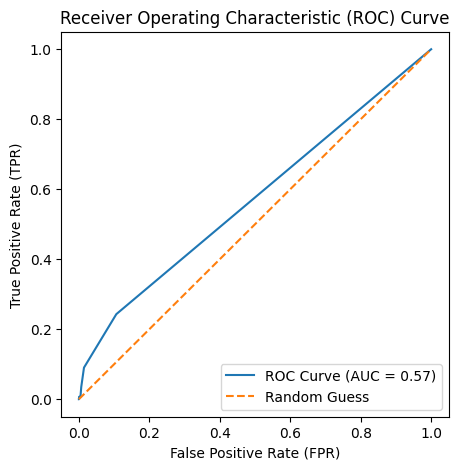

In [ ]:
knn_test_probabilities = knn_grid_search.predict_proba(test_predictors)[:, 1]

knn_fpr, knn_tpr, knn_thresholds = roc_curve(test_targets, knn_test_probabilities)

knn_roc_auc = auc(knn_fpr, knn_tpr)

plt.figure(figsize = (5, 5))
plt.plot(knn_fpr, knn_tpr, label = f'ROC Curve (AUC = {knn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random Guess')
contextualize('K-Nearest Neighbors ROC Curve')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7199
           1       0.03      0.01      0.01       144

    accuracy                           0.98      7343
   macro avg       0.51      0.50      0.50      7343
weighted avg       0.96      0.98      0.97      7343



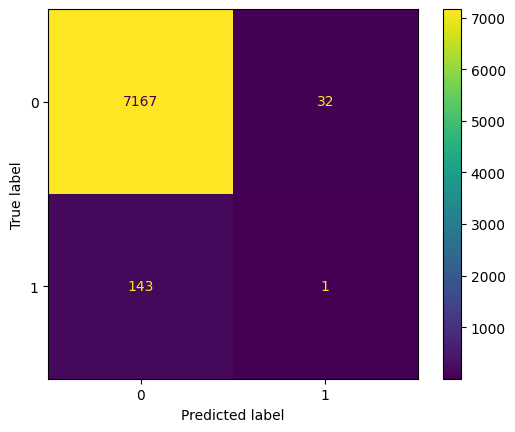

In [ ]:
knn_test_predictions = knn_grid_search.predict(test_predictors)

print(classification_report(test_targets, knn_test_predictions))

knn_confusion_matrix = confusion_matrix(test_targets, knn_test_predictions)

ConfusionMatrixDisplay(knn_confusion_matrix).plot()

#### *Naive Bayes*

In [ ]:
naive_bayes_pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

naive_bayes_parameter_grid = {
    'classifier__var_smoothing': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

naive_bayes_cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

naive_bayes_grid_search = GridSearchCV(naive_bayes_pipeline, naive_bayes_parameter_grid, cv = naive_bayes_cross_validation, n_jobs = -1, scoring = 'roc_auc')

naive_bayes_grid_search.fit(train_predictors, train_targets)

naive_bayes_auc = naive_bayes_grid_search.score(test_predictors, test_targets)

print('Naive Bayes Best AUC Score: {:.2f}'.format(naive_bayes_grid_search.best_score_))
print('Naive Bayes Best Parameters:', naive_bayes_grid_search.best_params_)
print('Naive Bayes Test AUC Score: {:.2f}'.format(naive_bayes_auc))

Naive Bayes Best AUC Score: 0.71%
Naive Bayes Best Parameters: {'classifier__var_smoothing': 1e-07}
Naive Bayes Test AUC Score: 0.72%


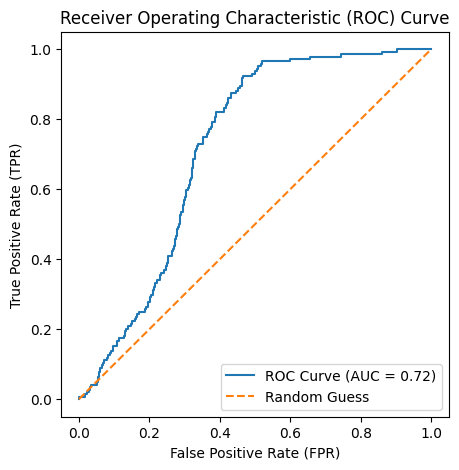

In [ ]:
naive_bayes_test_probabilities = naive_bayes_grid_search.predict_proba(test_predictors)[:, 1]

naive_bayes_fpr, naive_bayes_tpr, naive_bayes_thresholds = roc_curve(test_targets, naive_bayes_test_probabilities)

naive_bayes_roc_auc = auc(naive_bayes_fpr, naive_bayes_tpr)

plt.figure(figsize = (5, 5))
plt.plot(naive_bayes_fpr, naive_bayes_tpr, label = f'ROC Curve (AUC = {naive_bayes_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random Guess')
contextualize('Naive Bayes ROC Curve')

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7199
           1       0.03      0.22      0.05       144

    accuracy                           0.83      7343
   macro avg       0.50      0.53      0.48      7343
weighted avg       0.96      0.83      0.89      7343



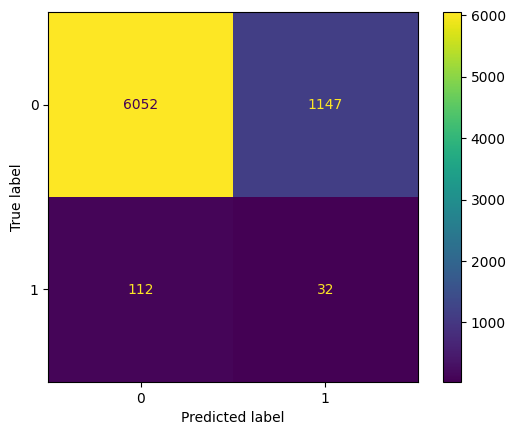

In [54]:
naive_bayes_test_predictions = naive_bayes_grid_search.predict(test_predictors)

print(classification_report(test_targets, naive_bayes_test_predictions))

naive_bayes_confusion_matrix = confusion_matrix(test_targets, naive_bayes_test_predictions)

ConfusionMatrixDisplay(naive_bayes_confusion_matrix).plot()

#### *Decision Tree*

In [ ]:
decision_tree_pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state = 10))
])

decision_tree_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

decision_tree_cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

decision_tree_grid_search = GridSearchCV(decision_tree_pipeline, decision_tree_parameter_grid, cv = decision_tree_cross_validation, n_jobs = -1, scoring = 'roc_auc')

decision_tree_grid_search.fit(train_predictors, train_targets)

decision_tree_auc = decision_tree_grid_search.score(test_predictors, test_targets)

print('Decision Tree Best AUC Score: {:.2f}'.format(decision_tree_grid_search.best_score_))
print('Decision Tree Best Parameters:', decision_tree_grid_search.best_params_)
print('Decision Tree Test AUC Score: {:.2f}'.format(decision_tree_auc))

Decision Tree Best AUC Score: 0.83
Decision Tree Best Parameters: {'classifier__criterion': 'log_loss', 'classifier__max_features': 'sqrt', 'classifier__splitter': 'best'}
Decision Tree Test Score: 0.79


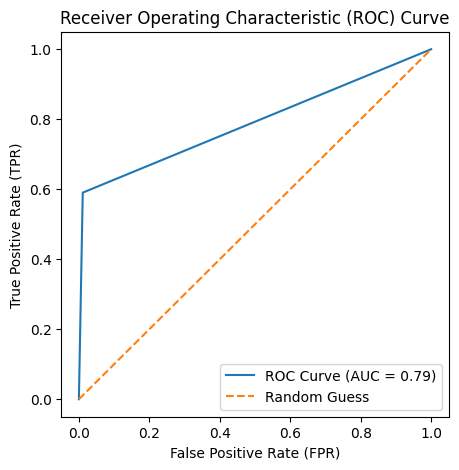

In [ ]:
decision_tree_test_probabilities = decision_tree_grid_search.predict_proba(test_predictors)[:, 1]

decision_tree_fpr, decision_tree_tpr, decision_tree_thresholds = roc_curve(test_targets, decision_tree_test_probabilities)

decision_tree_roc_auc = auc(decision_tree_fpr, decision_tree_tpr)

plt.figure(figsize = (5, 5))
plt.plot(decision_tree_fpr, decision_tree_tpr, label = f'ROC Curve (AUC = {decision_tree_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random Guess')
contextualize('Decision Tree ROC Curve')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7199
           1       0.52      0.59      0.55       144

    accuracy                           0.98      7343
   macro avg       0.76      0.79      0.77      7343
weighted avg       0.98      0.98      0.98      7343



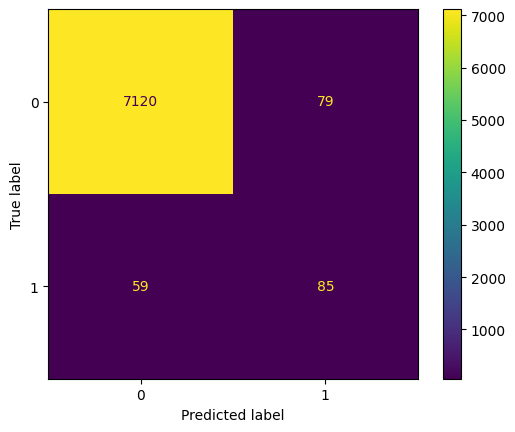

In [57]:
decision_tree_test_predictions = decision_tree_grid_search.predict(test_predictors)

print(classification_report(test_targets, decision_tree_test_predictions))

decision_tree_confusion_matrix = confusion_matrix(test_targets, decision_tree_test_predictions)

ConfusionMatrixDisplay(decision_tree_confusion_matrix).plot()

#### *Gradient Boosting*

In [64]:
gradient_boosting_pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state = 10))
])

gradient_boosting_parameter_grid = {
    'classifier__loss': ['log_loss', 'deviance', 'exponential'],
    'classifier__criterion': ['friedman_mse', 'squared_error'],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

gradient_boosting_cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

gradient_boosting_grid_search = GridSearchCV(gradient_boosting_pipeline, gradient_boosting_parameter_grid, cv = gradient_boosting_cross_validation, n_jobs = -1, scoring = 'roc_auc')

gradient_boosting_grid_search.fit(train_predictors, train_targets)

gradient_boosting_auc = gradient_boosting_grid_search.score(test_predictors, test_targets)

print('Gradient Boosting Best AUC Score: {:.2f}'.format(gradient_boosting_grid_search.best_score_))
print('Gradient Boosting Best Parameters:', gradient_boosting_grid_search.best_params_)
print('Gradient Boosting Test AUC Score: {:.2f}'.format(gradient_boosting_auc))

Gradient Boosting Best AUC Score: 0.95
Gradient Boosting Best Parameters: {'classifier__criterion': 'squared_error', 'classifier__loss': 'exponential', 'classifier__max_features': 'sqrt'}
Gradient Boosting Test AUC Score: 0.95


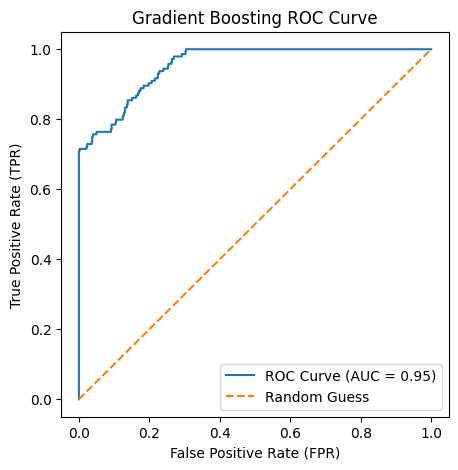

In [65]:
gradient_boosting_test_probabilities = gradient_boosting_grid_search.predict_proba(test_predictors)[:, 1]

gradient_boosting_fpr, gradient_boosting_tpr, gradient_boosting_thresholds = roc_curve(test_targets, gradient_boosting_test_probabilities)

gradient_boosting_roc_auc = auc(gradient_boosting_fpr, gradient_boosting_tpr)

plt.figure(figsize = (5, 5))
plt.plot(gradient_boosting_fpr, gradient_boosting_tpr, label = f'ROC Curve (AUC = {gradient_boosting_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random Guess')
contextualize('Gradient Boosting ROC Curve')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7199
           1       0.98      0.71      0.82       144

    accuracy                           0.99      7343
   macro avg       0.99      0.85      0.91      7343
weighted avg       0.99      0.99      0.99      7343



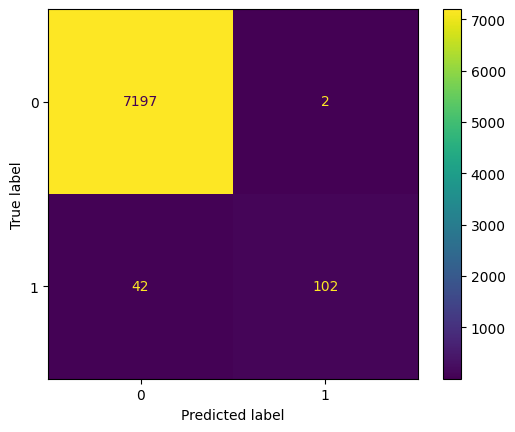

In [66]:
gradient_boosting_test_predictions = gradient_boosting_grid_search.predict(test_predictors)

print(classification_report(test_targets, gradient_boosting_test_predictions))

gradient_boosting_confusion_matrix = confusion_matrix(test_targets, gradient_boosting_test_predictions)

ConfusionMatrixDisplay(gradient_boosting_confusion_matrix).plot()

#### *Random Forest*

In [58]:
random_forest_pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state = 10))
])

random_forest_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_features': ['sqrt', 'log2'],
}

random_forest_cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

random_forest_grid_search = GridSearchCV(random_forest_pipeline, random_forest_parameter_grid, cv = random_forest_cross_validation, n_jobs = -1, scoring = 'roc_auc')

random_forest_grid_search.fit(train_predictors, train_targets)

random_forest_auc = random_forest_grid_search.score(test_predictors, test_targets)

print('Random Forest Best AUC Score: {:.2f}'.format(random_forest_grid_search.best_score_))
print('Random Forest Best Parameters:', random_forest_grid_search.best_params_)
print('Random Forest Test AUC Score: {:.2f}'.format(random_forest_auc))

Random Forest Best AUC Score: 0.93
Random Forest Best Parameters: {'classifier__criterion': 'log_loss', 'classifier__max_features': 'sqrt'}
Random Forest Test AUC Score: 0.93


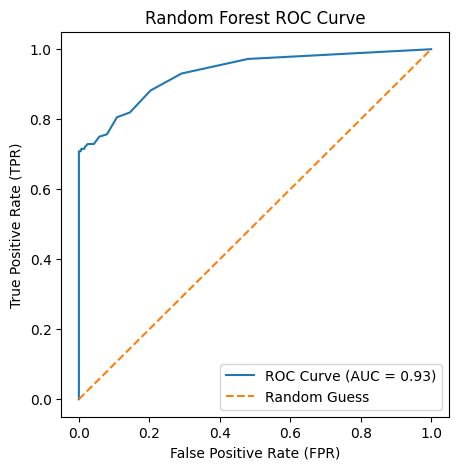

In [60]:
random_forest_test_probabilities = random_forest_grid_search.predict_proba(test_predictors)[:, 1]

random_forest_fpr, random_forest_tpr, random_forest_thresholds = roc_curve(test_targets, random_forest_test_probabilities)

random_forest_roc_auc = auc(random_forest_fpr, random_forest_tpr)

plt.figure(figsize = (5, 5))
plt.plot(random_forest_fpr, random_forest_tpr, label = f'ROC Curve (AUC = {random_forest_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random Guess')
contextualize('Random Forest ROC Curve')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7199
           1       1.00      0.70      0.82       144

    accuracy                           0.99      7343
   macro avg       1.00      0.85      0.91      7343
weighted avg       0.99      0.99      0.99      7343



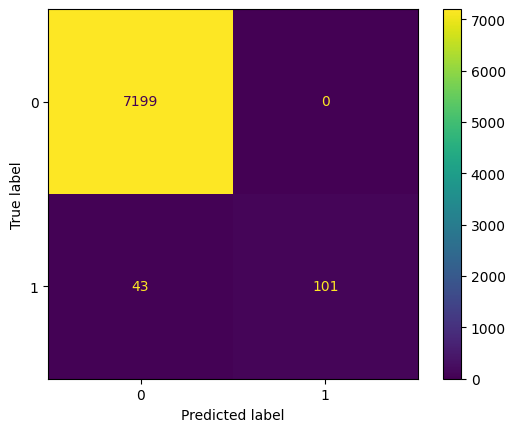

In [61]:
random_forest_test_predictions = random_forest_grid_search.predict(test_predictors)

print(classification_report(test_targets, random_forest_test_predictions))

random_forest_confusion_matrix = confusion_matrix(test_targets, random_forest_test_predictions)

ConfusionMatrixDisplay(random_forest_confusion_matrix).plot()

#### *AdaBoost*

In [76]:
ada_boost_pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('classifier', AdaBoostClassifier(random_state = 10))
])

ada_boost_parameter_grid = {
    'classifier__estimator': [DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_features = 'auto', random_state = 10),
                              DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_features = 'sqrt', random_state = 10),
                              DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_features = 'log2', random_state = 10),
                              DecisionTreeClassifier(criterion = 'gini', splitter = 'random', max_features = 'auto', random_state = 10),
                              DecisionTreeClassifier(criterion = 'gini', splitter = 'random', max_features = 'sqrt', random_state = 10),
                              DecisionTreeClassifier(criterion = 'gini', splitter = 'random', max_features = 'log2', random_state = 10),
                              DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_features = 'auto', random_state = 10),
                              DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_features = 'sqrt', random_state = 10),
                              DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_features = 'log2', random_state = 10),
                              DecisionTreeClassifier(criterion = 'entropy', splitter = 'random', max_features = 'auto', random_state = 10),
                              DecisionTreeClassifier(criterion = 'entropy', splitter = 'random', max_features = 'sqrt', random_state = 10),
                              DecisionTreeClassifier(criterion = 'entropy', splitter = 'random', max_features = 'log2', random_state = 10),
                              DecisionTreeClassifier(criterion = 'log_loss', splitter = 'best', max_features = 'auto', random_state = 10),
                              DecisionTreeClassifier(criterion = 'log_loss', splitter = 'best', max_features = 'sqrt', random_state = 10),
                              DecisionTreeClassifier(criterion = 'log_loss', splitter = 'best', max_features = 'log2', random_state = 10),
                              DecisionTreeClassifier(criterion = 'log_loss', splitter = 'random', max_features = 'auto', random_state = 10),
                              DecisionTreeClassifier(criterion = 'log_loss', splitter = 'random', max_features = 'sqrt', random_state = 10),
                              DecisionTreeClassifier(criterion = 'log_loss', splitter = 'random', max_features = 'log2', random_state = 10)]
}

ada_boost_cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

ada_boost_grid_search = GridSearchCV(ada_boost_pipeline, ada_boost_parameter_grid, cv = ada_boost_cross_validation, n_jobs = -1, scoring = 'roc_auc')

ada_boost_grid_search.fit(train_predictors, train_targets)

ada_boost_auc = ada_boost_grid_search.score(test_predictors, test_targets)

print('AdaBoost Best AUC Score: {:.2f}'.format(ada_boost_grid_search.best_score_))
print('AdaBoost Best Parameters:', ada_boost_grid_search.best_params_)
print('AdaBoost Test AUC Score: {:.2f}'.format(ada_boost_auc))

AdaBoost Best AUC Score: 0.83
AdaBoost Best Parameters: {'classifier__estimator': DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=10)}
AdaBoost Test AUC Score: 0.83


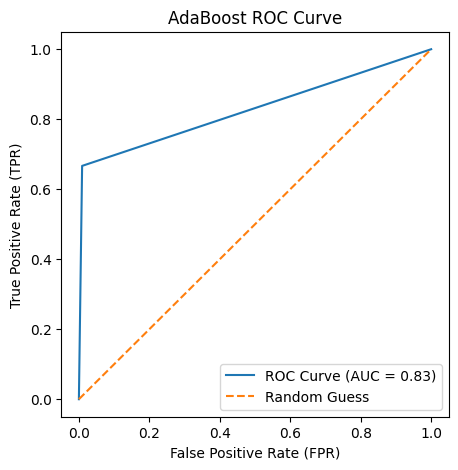

In [77]:
ada_boost_test_probabilities = ada_boost_grid_search.predict_proba(test_predictors)[:, 1]

ada_boost_fpr, ada_boost_tpr, ada_boost_thresholds = roc_curve(test_targets, ada_boost_test_probabilities)

ada_boost_roc_auc = auc(ada_boost_fpr, ada_boost_tpr)

plt.figure(figsize = (5, 5))
plt.plot(ada_boost_fpr, ada_boost_tpr, label = f'ROC Curve (AUC = {ada_boost_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random Guess')
contextualize('AdaBoost ROC Curve')

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7199
           1       0.59      0.67      0.63       144

    accuracy                           0.98      7343
   macro avg       0.79      0.83      0.81      7343
weighted avg       0.99      0.98      0.98      7343



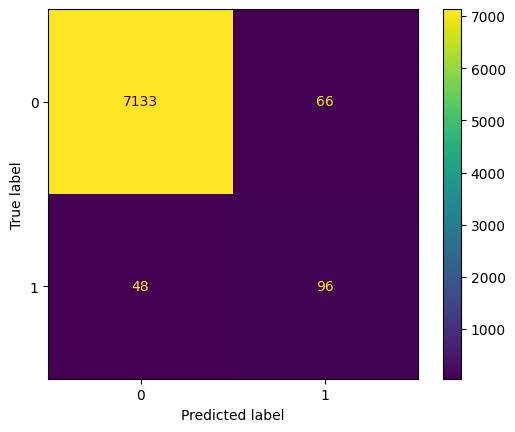

In [78]:
ada_boost_test_predictions = ada_boost_grid_search.predict(test_predictors)

print(classification_report(test_targets, ada_boost_test_predictions))

ada_boost_confusion_matrix = confusion_matrix(test_targets, ada_boost_test_predictions)

ConfusionMatrixDisplay(ada_boost_confusion_matrix).plot()

#### *Support Vector Machine*

In [ ]:
svm_pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('classifier', SVC( probability = True, random_state = 10))
])

svm_parameter_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

svm_cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

svm_grid_search = GridSearchCV(svm_pipeline, svm_parameter_grid, cv = svm_cross_validation, n_jobs = -1, scoring = 'roc_auc')

svm_grid_search.fit(train_predictors, train_targets)

svm_auc = svm_grid_search.score(test_predictors, test_targets)

print('Support Vector Machine Best AUC Score: {:.2f}'.format(svm_grid_search.best_score_))
print('Support Vector Machine Best Parameters:', svm_grid_search.best_params_)
print('Support Vector Machine Test AUC Score: {:.2f}'.format(svm_auc))

KeyboardInterrupt: 

In [ ]:
svm_test_probabilities = svm_grid_search.predict_proba(test_predictors)[:, 1]

svm_fpr, svm_tpr, svm_thresholds = roc_curve(test_targets, svm_test_probabilities)

svm_roc_auc = auc(svm_fpr, svm_tpr)

plt.figure(figsize = (5, 5))
plt.plot(svm_fpr, svm_tpr, label = f'ROC Curve (AUC = {svm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random Guess')
contextualize('Support Vector Machine ROC Curve')

In [ ]:
svm_test_predictions = svm_grid_search.predict(test_predictors)

print(classification_report(test_targets, svm_test_predictions))

svm_confusion_matrix = confusion_matrix(test_targets, svm_test_predictions)

ConfusionMatrixDisplay(svm_confusion_matrix).plot()

#### *Neural Network*

In [ ]:
neural_network_pipeline = Pipeline([
    ('smote', SMOTE()),
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state = 10))
])

neural_network_parameter_grid = {
    'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'classifier__solver': ['lbfgs', 'sgd', 'adam'],
}

neural_network_cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

neural_network_grid_search = GridSearchCV(neural_network_pipeline, neural_network_parameter_grid, cv = neural_network_cross_validation, n_jobs = -1, scoring = 'roc_auc')

neural_network_grid_search.fit(train_predictors, train_targets)

neural_network_auc = neural_network_grid_search.score(test_predictors, test_targets)

print('Neural Network Best AUC Score: {:.2f}'.format(neural_network_grid_search.best_score_))
print('Neural Network Best Parameters:', neural_network_grid_search.best_params_)
print('Neural Network Test AUC Score: {:.2f}'.format(neural_network_auc))

KeyboardInterrupt: 

In [ ]:
neural_network_test_probabilities = neural_network_grid_search.predict_proba(test_predictors)[:, 1]

neural_network_fpr, neural_network_tpr, neural_network_thresholds = roc_curve(test_targets, neural_network_test_probabilities)

neural_network_roc_auc = auc(neural_network_fpr, neural_network_tpr)

plt.figure(figsize = (5, 5))
plt.plot(neural_network_fpr, neural_network_tpr, label = f'ROC Curve (AUC = {neural_network_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random Guess')
contextualize('Neural Network ROC Curve')

In [ ]:
neural_network_test_predictions = neural_network_grid_search.predict(test_predictors)

print(classification_report(test_targets, neural_network_test_predictions))

neural_network_confusion_matrix = confusion_matrix(test_targets, neural_network_test_predictions)

ConfusionMatrixDisplay(neural_network_confusion_matrix).plot()

### Avaliação dos Modelos

## Avaliação

### Avaliação dos Resultados

In [81]:
models = [knn_grid_search, naive_bayes_grid_search, decision_tree_grid_search, gradient_boosting_grid_search, random_forest_grid_search, ada_boost_grid_search, neural_network_grid_search]
labels = ['K-Nearest Neighbors', 'Naive Bayes', 'Decision Tree', 'Gradient Boosting', 'Random Forest', 'AdaBoost', 'Neural Network']

scores = []
for model in models:
    pipeline = Pipeline([
        ['smote', SMOTE()],
        ['scaler', StandardScaler()],
        ['classifier', model]
    ])
    score = model.score(test_predictors, test_targets)
    scores.append(score)

plt.figure(figsize = (20, 10))
plt.boxplot(scores, labels = labels)
plt.title('Area Under Curve (AUC)')

NameError: name 'neural_network_grid_search' is not defined

### Revisão do Processo

### Determinação dos Próximos Passos

## Produção

In [80]:
customers = pd.read_csv('kaggle/customers.csv')
merchants = pd.read_csv('kaggle/merchants.csv')
transactions = pd.read_csv('kaggle/test_transactions.csv')

def data_selection(transactions):
    transactions = transactions.drop('trans_date_trans_time', axis = 1)
    return transactions

def data_cleaning(transactions):
    transactions['device_os'] = transactions['device_os'].fillna('unknown')
    transactions = transactions.drop('trans_num', axis = 1)
    return transactions

def data_construction(transactions):
    # day, month, weekday
    timestamp = pd.to_datetime(transactions['unix_time'], unit = 's')
    transactions['day'] = timestamp.dt.day
    transactions['month'] = timestamp.dt.month
    transactions['weekday'] = timestamp.dt.weekday
    # days_since_last_transaction
    transactions = transactions.sort_values(by = ['cc_num', 'unix_time'])
    transactions['days_since_last_transaction'] = transactions.groupby('cc_num')['unix_time'].diff()
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'] / (60 * 60 * 24)
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'].fillna(0)
    # merchant_transactions_count
    transactions = transactions.sort_values(by = ['cc_num', 'merchant', 'unix_time'])
    transactions['merchant_transactions_count'] = transactions.groupby(['cc_num', 'merchant']).cumcount()
    transactions = transactions.drop('unix_time', axis = 1)
    return transactions

def data_integration(transactions, merchants, customers):
    data = transactions.merge(merchants, on = 'merchant').merge(customers, on = 'cc_num')
    data = data.drop(['cc_num', 'merchant'], axis = 1)
    return data

def data_formatting(data):
    data = pd.get_dummies(data, drop_first = False)
    data['device_os_Linux'] = False # TODO
    data = data.sort_index(axis = 1)
    return data

data = transactions.pipe(data_selection).pipe(data_cleaning).pipe(data_construction).pipe(data_integration, merchants, customers).pipe(data_formatting)

data.head()

,age,amt,category_Apparel,category_Electronics,category_Entertainment,category_Groceries,category_Travel,city_Chicago,city_Houston,city_Los Angeles,...,job_Artist,job_Clerk,job_Doctor,job_Engineer,job_Lawyer,job_Nurse,job_Teacher,merchant_transactions_count,month,weekday
0,31,483.368265,False,False,False,True,False,True,False,False,...,False,False,False,True,False,False,False,0,12,2
1,21,236.803300,False,False,False,True,False,True,False,False,...,False,False,False,False,False,True,False,0,8,3
2,21,181.193456,False,False,True,False,False,True,False,False,...,False,False,False,False,False,True,False,0,2,0
3,29,22.241488,True,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,0,9,5
4,69,293.482287,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,0,1,1


In [87]:
model = random_forest_grid_search
score = model.score(test_predictors, test_targets)

print('Best AUC Score: {:.2f}'.format(model.best_score_))
print('Best Parameters:', model.best_params_)
print('Test AUC Score: {:.2f}'.format(score))

print(classification_report(test_targets, model.predict(test_predictors)))

probabilities = model.predict_proba(data)[:, 1]

predictions = pd.DataFrame({
    'index': data['index'],
    'is_fraud': probabilities
})

predictions.to_csv('kaggle/predictions.csv', index = False)

Best AUC Score: 0.93
Best Parameters: {'classifier__criterion': 'log_loss', 'classifier__max_features': 'sqrt'}
Test AUC Score: 0.93
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7199
           1       1.00      0.70      0.82       144

    accuracy                           0.99      7343
   macro avg       1.00      0.85      0.91      7343
weighted avg       0.99      0.99      0.99      7343

